## Survival Models :- COX , PenalizedCOX , Random Forest Surviavl

In [77]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings



In [78]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.utils.class_weight import compute_sample_weight


#### 1.1 Data Cleaning

In [81]:
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

In [83]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The number of admissions aged over 100 years old is: 2616 admissions (5.15% over all admissions)
The median age of patients: 65


In [85]:
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

##### 1.2 Data Exploration

In [87]:
df_demographic[df_demographic['IS_SEPSIS'] == 1]["DEATHTIME"].isna().value_counts()

DEATHTIME
True     3581
False    1595
Name: count, dtype: int64

#### Data Loader

In [88]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 2.1 Survival Analysis

In [89]:
# final data frame
#df_final = dataLoader.extract_train_data_by_features(df_labevents, df_demographic,df_desc_labitems, 4,ROOT_DIR/'data/potential_labevents_count_with_proportion.csv', 30)

In [90]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t4.csv"  
t4 = pd.read_csv(path_t4_df)

In [92]:
df_demographic['last_seen'] = df_demographic['DEATHTIME'].fillna(df_demographic['DISCHTIME'])
df_demographic['last_seen'] =  pd.to_datetime(df_demographic['last_seen'], format='%Y-%m-%d %H:%M:%S')
df_demographic["total_stay"]  = (df_demographic["last_seen"] - df_demographic["ADMITTIME"]).dt.total_seconds() / 3600
df_demographic["total_stay"] = df_demographic["total_stay"].round()
df_demographic["status"] = df_demographic["DEATHTIME"].notna()

In [95]:
#dropping the rows which have negative total stay i.e. discharge time less than admit time
df_demographic = df_demographic[df_demographic["total_stay"] >= 0]

In [96]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [97]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50821,ITEMID_50862,ITEMID_50882,ITEMID_50893,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,total_stay,status
0,3,145834,76,0,0,8.0,329.0,1.8,11.0,7.4,...,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1,259.0,False
1,4,185777,47,1,0,-999.0,-999.0,-999.0,24.0,8.9,...,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7,186.0,False
2,6,107064,65,1,0,1.9,153.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.0,-999.0,30.0,-999.0,...,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5,117.0,True
4,11,194540,50,1,0,-999.0,-999.0,-999.0,25.0,-999.0,...,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45702,99983,117390,78,0,0,-999.0,-999.0,-999.0,28.0,9.4,...,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5,74.0,False
45703,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0,398.0,False
45704,99992,197084,65,1,0,-999.0,-999.0,2.0,22.0,7.1,...,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4,72.0,False
45705,99995,137810,88,1,0,1.1,382.0,-999.0,-999.0,-999.0,...,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0,77.0,False


In [98]:
#df = df.drop(df[(df['is_sepsis'] == 1) & (df['Death_time'].isna())].index)

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [99]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)

In [100]:
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [101]:
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)

test_sepsis = data_x_test["IS_SEPSIS"]
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [102]:
df_test = pd.concat([data_x_test, data_y_test], axis=1)
df_test[df_test["total_stay"] < 100]

,AGE,GENDER_NUM,ITEMID_50813,ITEMID_50821,ITEMID_50862,ITEMID_50882,ITEMID_50893,ITEMID_50902,ITEMID_50912,ITEMID_50931,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,status,total_stay
32361,55,1,2.3,-999.0,-999.0,30.0,-999.0,97.0,0.7,57.0,...,-999.0,4.4,91.0,260.0,-999.0,15.3,4.62,15.1,False,69.0
31481,60,0,3.2,-999.0,-999.0,-999.0,8.9,-999.0,3.5,-999.0,...,1.2,11.7,83.1,225.0,13.7,15.4,4.34,13.3,False,98.0
13170,85,1,2.4,198.0,-999.0,17.0,7.3,109.0,2.3,177.0,...,1.0,-999.0,-999.0,303.0,12.6,13.0,3.66,8.9,True,68.0
30601,76,0,0.8,-999.0,1.8,20.0,7.7,98.0,1.1,104.0,...,1.6,90.0,8.0,11.0,17.0,15.5,2.56,0.5,False,61.0
24912,34,1,-999.0,-999.0,-999.0,24.0,-999.0,105.0,0.8,91.0,...,-999.0,46.1,47.4,199.0,-999.0,14.3,4.36,6.9,False,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24999,64,0,0.8,379.0,-999.0,22.0,-999.0,99.0,6.1,124.0,...,1.9,15.8,78.5,498.0,20.3,15.7,3.83,13.0,True,51.0
26300,88,0,1.6,-999.0,-999.0,-999.0,-999.0,-999.0,1.3,-999.0,...,1.2,-999.0,-999.0,222.0,14.0,12.6,4.74,10.5,False,90.0
32891,41,1,-999.0,-999.0,3.2,23.0,8.7,108.0,1.2,100.0,...,1.1,-999.0,-999.0,181.0,11.8,14.5,4.48,4.1,False,23.0
11248,39,0,-999.0,-999.0,-999.0,31.0,9.5,99.0,8.3,320.0,...,-999.0,-999.0,-999.0,281.0,-999.0,19.6,4.17,12.4,False,75.0


In [103]:
#data_y = df_required[["status","total_stay"]].to_numpy()
#data_y = df_required[["status","total_stay"]].to_records(index=False)
#np.array(data_y)
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False, 274.), (False, 155.), (False, 214.), ...,
           (False, 429.), (False, 264.), (False, 152.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [104]:
#data_x = df_required.drop(["status","total_stay","SUBJECT_ID","HADM_ID","IS_SEPSIS"], axis = 1)

In [106]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

In [107]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [108]:
pd.Series(estimator.coef_, index=data_x_train.columns)

AGE             0.025159
GENDER_NUM      0.074630
ITEMID_50813    0.000426
ITEMID_50821    0.000361
ITEMID_50862    0.000107
ITEMID_50882   -0.000432
ITEMID_50893    0.000049
ITEMID_50902   -0.000033
ITEMID_50912   -0.000916
ITEMID_50931    0.000091
ITEMID_50970    0.000204
ITEMID_51006    0.002116
ITEMID_51221   -0.000893
ITEMID_51222    0.000084
ITEMID_51237   -0.000926
ITEMID_51244   -0.003600
ITEMID_51256    0.003692
ITEMID_51265   -0.000939
ITEMID_51274    0.000987
ITEMID_51277    0.000149
ITEMID_51279   -0.000583
ITEMID_51301    0.002270
dtype: float64

In [151]:
#pred_surv = estimator.predict_survival_function(data_x_test[:25])
pred_surv = estimator.predict_survival_function(data_x_test[2400:2500])


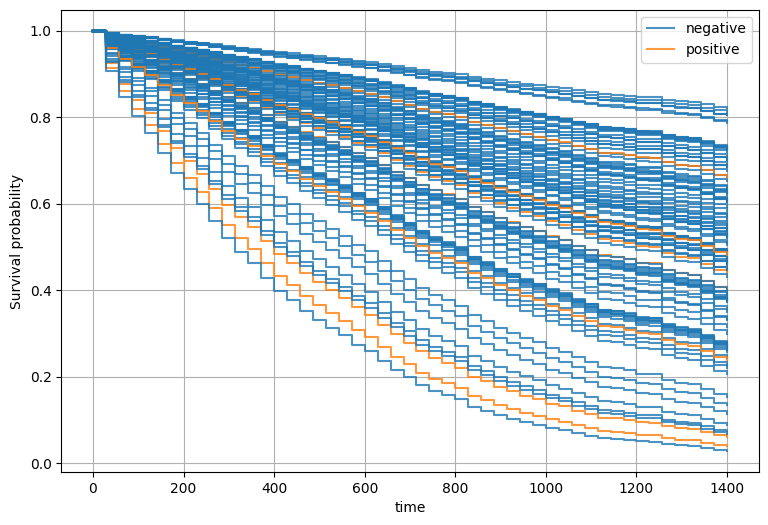

In [164]:
#surv_fns = coxnet_pred.predict_survival_function(data_x_test[100:200])

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [111]:
legend_labels

['negative']

In [112]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_test)
result = concordance_index_censored(data_y_test["status"], data_y_test["total_stay"], prediction)
result[0]

0.7100560106615221

In [113]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)

ITEMID_50813    0.644245
ITEMID_51006    0.631943
ITEMID_51274    0.620282
ITEMID_51237    0.619390
ITEMID_51301    0.619211
ITEMID_50912    0.615009
ITEMID_51277    0.604423
AGE             0.595786
ITEMID_50970    0.581458
ITEMID_50821    0.574006
ITEMID_50931    0.573619
ITEMID_51256    0.569009
ITEMID_50893    0.534688
ITEMID_50902    0.531100
GENDER_NUM      0.519604
ITEMID_51221    0.519224
ITEMID_50862    0.508159
ITEMID_51222    0.500755
ITEMID_51279    0.498047
ITEMID_51244    0.494829
ITEMID_51265    0.490337
ITEMID_50882    0.438313
dtype: float64

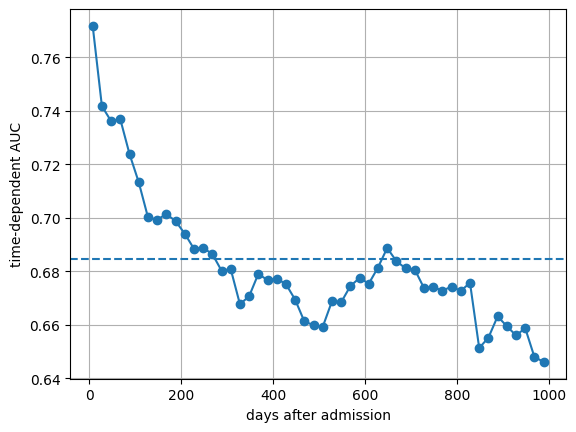

In [114]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days after admission")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [115]:


pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

In [116]:
"""
from sklearn.model_selection import GridSearchCV, KFold

#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}
param_grid = {"select__k": np.arange(15, 19 + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x_train, data_y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

"""

'\nfrom sklearn.model_selection import GridSearchCV, KFold\n\n#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}\nparam_grid = {"select__k": np.arange(15, 19 + 1)}\ncv = KFold(n_splits=3, random_state=1, shuffle=True)\ngcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)\ngcv.fit(data_x_train, data_y_train)\n\nresults = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)\nresults.loc[:, ~results.columns.str.endswith("_time")]\n\n'

In [117]:
Xt = data_x_train.copy()
y = data_y_train.copy()

# Penalized cox

In [118]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.8, alpha_min_ratio=0.001, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.8,
                                        max_iter=100))])

In [119]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

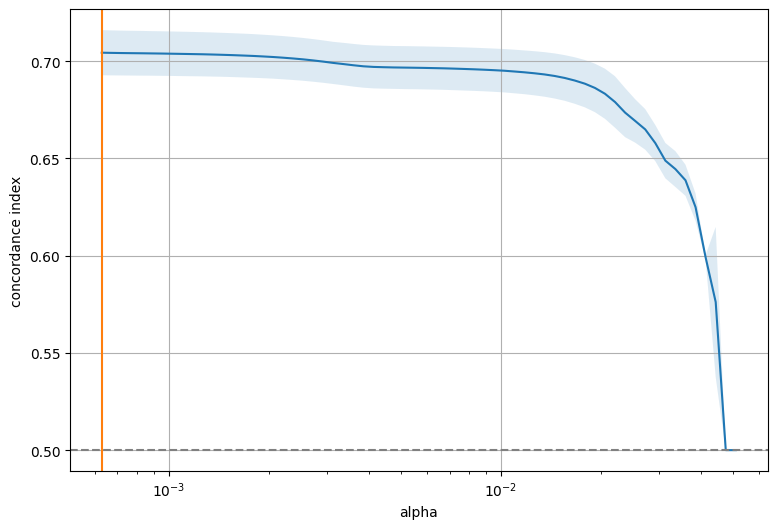

In [120]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 16


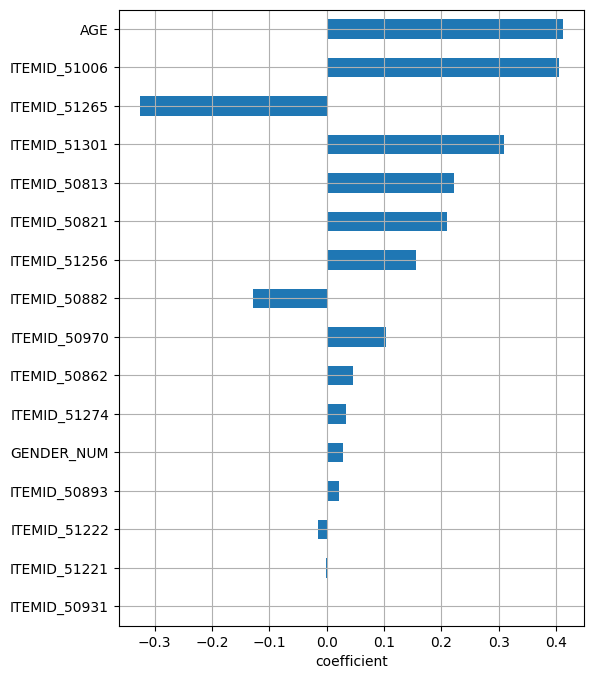

In [121]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

# bit change fr checking
#best_model = CoxnetSurvivalAnalysis()
#best_model.fit(Xt,y)

#print(best_model.coef_)


#### till here


best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [122]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.0006279462192230565],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

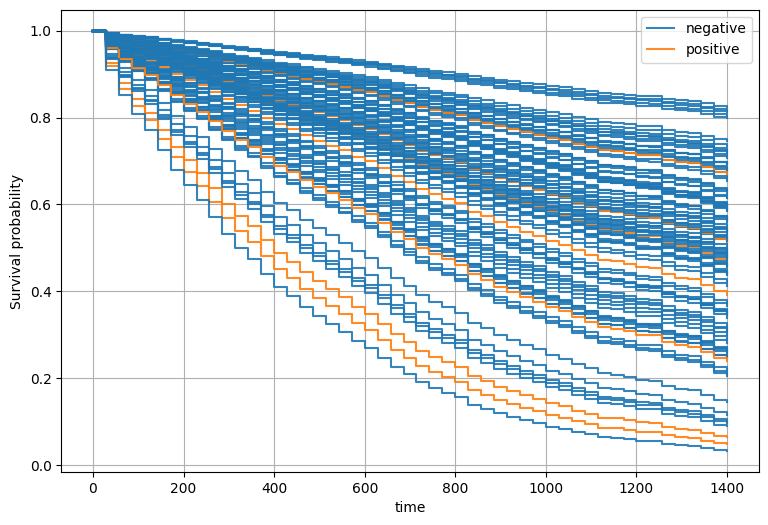

In [167]:
surv_fns = coxnet_pred.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)



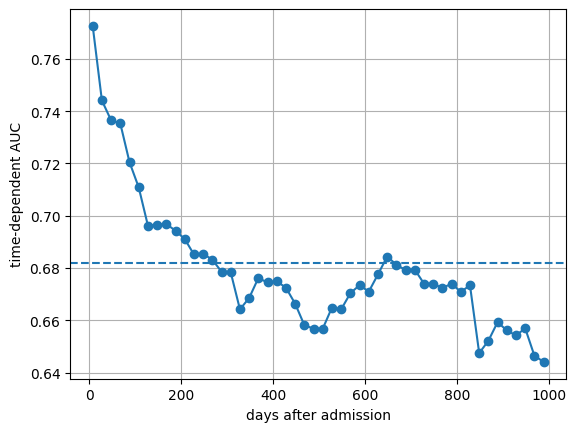

In [124]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days after admission")
plt.ylabel("time-dependent AUC")
plt.grid(True)

### elastic net penalty

In [125]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9)

In [126]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

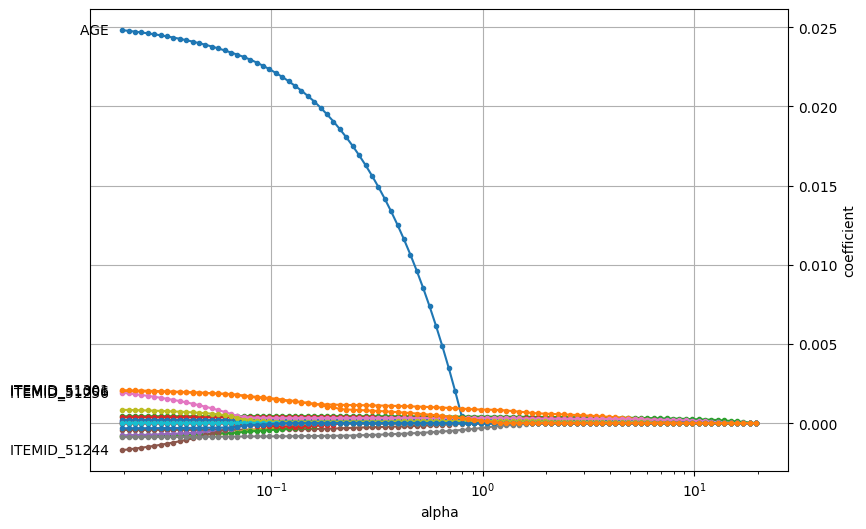

In [127]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_,5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [169]:
surv_fns = coxnet_pred.predict(data_x_test)
result = concordance_index_censored(data_y_test["status"], data_y_test["total_stay"], surv_fns)
result[0]

0.7065725013760713

## Random forest survival

In [170]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [171]:
y

rec.array([(False, 274.), (False, 155.), (False, 214.), ...,
           (False, 429.), (False, 264.), (False, 152.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [172]:
rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)

RandomSurvivalForest(max_depth=2, random_state=1)

In [173]:
sample_weights_testing = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_test])

In [174]:
rsf_gbsg.score(data_x_test, data_y_test)

0.7133069854329801

In [182]:

score_cindex = pd.Series(
    [
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

RSF       0.713
Coxnet    0.707
cph       0.710
Random    0.500
Name: c-index, dtype: float64

In [183]:
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

In [184]:
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [186]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
RSF,0.713,0.106
Coxnet,0.707,0.106
cph,0.710,0.106
Random,0.500,0.251


In [179]:
df_required[["status","total_stay"]].to_records(index=False)

rec.array([(False, 259.), (False, 186.), (False, 393.), ...,
           (False,  72.), (False,  77.), (False, 129.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [180]:
rsf_gbsg.score(data_x_test, data_y_test)

0.7133069854329801

In [188]:
# saving the survival model
import joblib
joblib.dump(rsf_gbsg, 'rsf_survival.pkl')

['rsf_survival.pkl']

In [189]:
# loading the model
loaded_rsf = joblib.load('rsf_survival.pkl')

In [190]:
loaded_rsf.score(data_x_test, data_y_test)

0.7133069854329801

In [ ]:
sample_weights_testing = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_test])